## **Model Tuning Notebook**

In [1]:
from numba import cuda
import tensorflow as tf

def clear_gpu_memory():
    device = cuda.get_current_device()
    device.reset() # dump the memory contents to free up the memory (it accumulates over the session)
    
# CUDA (Nvidia GPU Computing)
if len(tf.config.list_physical_devices('GPU')) > 0:
    gpus = tf.config.list_physical_devices('GPU')
    print("Num GPUs Available: ", len(gpus))
    
    clear_gpu_memory()
    
    tf.config.experimental.set_memory_growth(gpus[0], True)

    tf.config.set_logical_device_configuration(
    gpus[0], 
    [tf.config.LogicalDeviceConfiguration(memory_limit=8192)])  # limit to 4GB

    tf.compat.v1.disable_eager_execution()


Num GPUs Available:  1


In [2]:
# because the utils in the src are designed to be run from the root of the project,
# and by default jupyter runs from the notebook directory we need to change the working directory to the root

import os
import sys
sys.path.append('../')

def find_project_root(filename=".git"): # .git is located in the root of the project
    current_dir = os.getcwd()
    while current_dir != os.path.dirname(current_dir): # stops only when at the root (moves up 1 level each iteration)
        if filename in os.listdir(current_dir):
            return current_dir
        current_dir = os.path.dirname(current_dir)

project_root = find_project_root()
os.chdir(project_root)  # change the working directory to the project root

print("Project root:", project_root, "CWD:", os.getcwd())

Project root: d:\deep_learning_project CWD: d:\deep_learning_project


In [3]:
%load_ext autoreload
%autoreload 2

import kerastuner as kt

from src.utils.modeling import *
from src.utils.preproc import *
from src.utils.visualizations import *

from keras.models import Model, Sequential, load_model
from keras.applications import VGG16, InceptionV3
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

from sklearn.metrics import classification_report

C:\Users\vic\AppData\Local\Temp\ipykernel_40096\50664938.py:4: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


### **Binary Classification Models Fine-Tuning**

#### **Sequential**

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-7)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
callbacks = [reduce_lr, early_stopping]

tuner = kt.Hyperband(
    keras_tuning_model_builder,
    objective='val_loss',
    max_epochs=10,
    factor=2,
    directory='hyperband_logs',
    project_name='binary_breast_cancer_cnn',
)

train_gen, val_gen, test_gen, class_weights, steps_per_epoch = preproc_pipeline(
    image_resolution=(224, 224),
    classification_type='binary',
    csv_path='image_metadata/updated_image_data.csv',
    use_data_augmentation=False,
    augmented_images_per_image=5,
    batch_size=32
)

tuner.search(train_gen, validation_data=val_gen, epochs=10, callbacks=callbacks)

#### **Transfer Learning**

**VGG 16**

In [7]:
def binary_classification_vgg16_model(input_shape=(224, 224, 3), trainable_layers=10, learning_rate=0.0001):
    
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # train some layers and freeze others
    for layer in base_model.layers[:-trainable_layers]:
        layer.trainable = False
    for layer in base_model.layers[-trainable_layers:]:
        layer.trainable = True

    model = Sequential()
    
    model.add(base_model)
    
    model.add(Flatten())
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(1, activation='sigmoid'))
    
    # low learning rate for fine tuning
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [8]:
train_gen, val_gen, test_gen, class_weights, steps_per_epoch = preproc_pipeline(image_resolution=(224, 224),  
                                                    classification_type='binary',
                                                    use_data_augmentation=True,
                                                    augmented_images_per_image=5,
                                                    batch_size=32)

vgg16_binary = binary_classification_vgg16_model()

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-7)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
callbacks = [reduce_lr, early_stopping]
    

fitted_vgg16_binary = train_model(train_gen, val_gen, vgg16_binary, callbacks=callbacks, class_weights=class_weights, epochs=10, steps_per_epoch=steps_per_epoch)

Loading and preprocessing data...
Total training images after augmentation: 33198
Class weights computed.
Data generators created.
Epoch 1/10
860/860 [==============================] - ETA: 0s - batch: 429.5000 - size: 31.9826 - loss: 0.4522 - accuracy: 0.7839

c:\Users\vic\miniconda3\envs\tf\lib\site-packages\keras\engine\training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


860/860 [==============================] - 528s 595ms/step - batch: 429.5000 - size: 31.9826 - loss: 0.4522 - accuracy: 0.7839 - val_loss: 0.3988 - val_accuracy: 0.8516 - lr: 1.0000e-04
Epoch 2/10
860/860 [==============================] - 584s 679ms/step - batch: 429.5000 - size: 31.9826 - loss: 0.2203 - accuracy: 0.9131 - val_loss: 0.1514 - val_accuracy: 0.9401 - lr: 1.0000e-04
Epoch 3/10
860/860 [==============================] - 514s 597ms/step - batch: 429.5000 - size: 31.9826 - loss: 0.1701 - accuracy: 0.9322 - val_loss: 0.1296 - val_accuracy: 0.9469 - lr: 1.0000e-04
Epoch 4/10
860/860 [==============================] - 631s 733ms/step - batch: 429.5000 - size: 31.9860 - loss: 0.1352 - accuracy: 0.9460 - val_loss: 0.1589 - val_accuracy: 0.9376 - lr: 1.0000e-04
Epoch 5/10
860/860 [==============================] - 718s 834ms/step - batch: 429.5000 - size: 31.9791 - loss: 0.1035 - accuracy: 0.9583 - val_loss: 0.0914 - val_accuracy: 0.9646 - lr: 1.0000e-04
Epoch 6/10
860/860 [======

In [17]:
save_model(fitted_vgg16_binary, 'src/models/VGG16_binary')
save_training_history(fitted_vgg16_binary, 'src/models/VGG16_binary')

Loading test data...
Loading and preprocessing data...
Total training images (no augmentation): 5533
Class weights computed.
Data generators created.
Starting model evaluation...
Total number of samples in the test generator: 1186


d:\deep_learning_project\src\utils\modeling.py:102: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  # select the appropriate class names based on the classification type
c:\Users\vic\miniconda3\envs\tf\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,



Accuracy: 0.9848

Classification Report:
+-----------+-------------+----------+------------+-----------+
| Class     |   Precision |   Recall |   F1-Score |   Support |
+===========+=============+==========+============+===========+
| Benign    |    0.973262 | 0.978495 |   0.975871 |       372 |
+-----------+-------------+----------+------------+-----------+
| Malignant |    0.990148 | 0.987715 |   0.98893  |       814 |
+-----------+-------------+----------+------------+-----------+

Overall Metrics:
+------------------------+----------+
| Metric                 |    Value |
+========================+==========+
| Accuracy               | 0.984823 |
+------------------------+----------+
| Macro Avg Precision    | 0.981705 |
+------------------------+----------+
| Macro Avg Recall       | 0.983105 |
+------------------------+----------+
| Macro Avg F1-Score     | 0.982401 |
+------------------------+----------+
| Weighted Avg Precision | 0.984851 |
+------------------------+----------

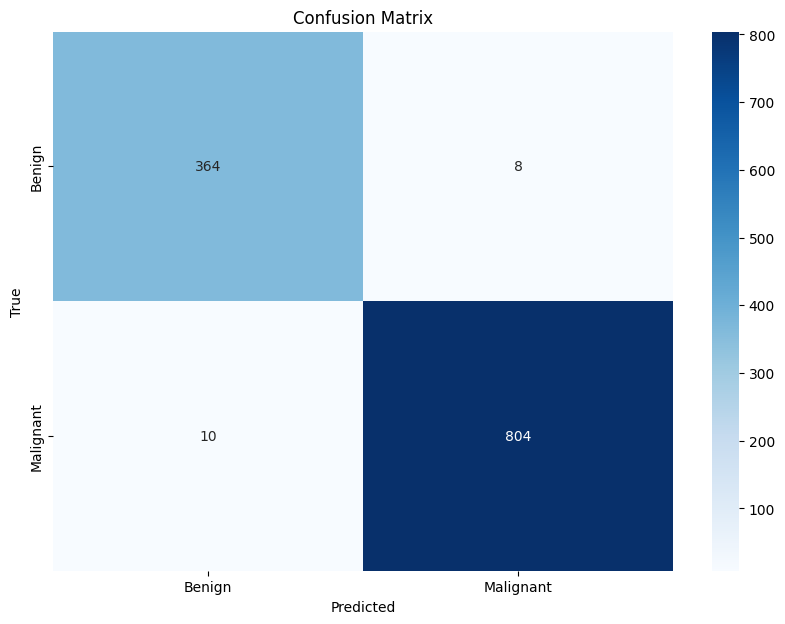

Evaluation complete. Returning results.


{'accuracy': 0.984822934232715,
 'classification_report': {'Benign': {'precision': 0.9732620320855615,
   'recall': 0.978494623655914,
   'f1-score': 0.9758713136729222,
   'support': 372.0},
  'Malignant': {'precision': 0.9901477832512315,
   'recall': 0.9877149877149877,
   'f1-score': 0.988929889298893,
   'support': 814.0},
  'accuracy': 0.984822934232715,
  'macro avg': {'precision': 0.9817049076683966,
   'recall': 0.9831048056854508,
   'f1-score': 0.9824006014859077,
   'support': 1186.0},
  'weighted avg': {'precision': 0.9848514093611562,
   'recall': 0.984822934232715,
   'f1-score': 0.9848339448361096,
   'support': 1186.0}},
 'confusion_matrix': array([[364,   8],
        [ 10, 804]], dtype=int64)}

In [20]:
fitted_vgg16_binary = load_model('src\models\VGG16_binary\saved_model.h5')
evaluate_model(fitted_vgg16_binary, classification_type='binary')

**InceptionV3**

In [4]:
def binary_classification_inceptionv3_model(input_shape=(224, 224, 3), trainable_layers=200, learning_rate=0.0001):
    
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # train some layers and freeze others
    for layer in base_model.layers[:-trainable_layers]:
        layer.trainable = False
    for layer in base_model.layers[-trainable_layers:]:
        layer.trainable = True

    model = Sequential()
    
    model.add(base_model)
    
    model.add(GlobalAveragePooling2D())
    
    model.add(Dense(1024, activation='relu'))
    
    model.add(Dense(1, activation='sigmoid'))
    
    # low learning rate for fine tuning
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [ ]:
train_gen, val_gen, test_gen, class_weights, steps_per_epoch = preproc_pipeline(image_resolution=(224, 224),  
                                                    classification_type='binary',
                                                    use_data_augmentation=True,
                                                    augmented_images_per_image=5,
                                                    batch_size=32)

inceptionv3_binary = binary_classification_inceptionv3_model()

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-7)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
callbacks = [reduce_lr, early_stopping]
    

fitted_inceptionv3_binary = train_model(train_gen, val_gen, inceptionv3_binary, callbacks=callbacks, class_weights=class_weights, epochs=40, steps_per_epoch=steps_per_epoch)

### **Multiclass Classification Models Fine-Tuning**

#### **Sequential**

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-7)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
callbacks = [reduce_lr, early_stopping]

tuner = kt.Hyperband(
    keras_tuning_model_builder,
    objective='val_loss',
    max_epochs=10,
    factor=2,
    directory='hyperband_logs',
    project_name='multiclass_breast_cancer_cnn',
)

train_gen, val_gen, test_gen, class_weights, steps_per_epoch = preproc_pipeline(
    image_resolution=(224, 224),
    classification_type='multiclass',
    csv_path='image_metadata/updated_image_data.csv',
    use_data_augmentation=True,
    augmented_images_per_image=5,
    batch_size=32
)
tuner.search(train_gen, validation_data=val_gen, epochs=10, callbacks=callbacks)

#### **Transfer Learning**

**VGG 16**

In [4]:
def multiclass_classification_vgg16_model(input_shape=(224, 224, 3), trainable_layers=10):
    
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # train some layers and freeze others
    for layer in base_model.layers[:-trainable_layers]:
        layer.trainable = False
    for layer in base_model.layers[-trainable_layers:]:
        layer.trainable = True

    model = Sequential()
    
    model.add(base_model)
    
    model.add(Flatten())
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(8, activation='softmax'))
    
    # low learning rate for fine tuning
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [ ]:
train_gen, val_gen, test_gen, class_weights, steps_per_epoch = preproc_pipeline(image_resolution=(224, 224), 
                                                    classification_type='multiclass',
                                                    use_data_augmentation=True,
                                                    augmented_images_per_image=5,
                                                    batch_size=32)
                                                    
vgg16_multiclass = multiclass_classification_vgg16_model()

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-7)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
callbacks = [reduce_lr, early_stopping]

fitted_vgg16_multiclass = train_model(train_gen, val_gen, vgg16_multiclass, callbacks=callbacks, class_weights=class_weights, epochs=20, steps_per_epoch=steps_per_epoch)

Loading and preprocessing data...
Total training images after augmentation: 33198
Class weights computed.
Data generators created.
Epoch 1/10
860/860 [==============================] - ETA: 0s - batch: 429.5000 - size: 31.9826 - loss: 1.9470 - accuracy: 0.1746

c:\Users\vic\miniconda3\envs\tf\lib\site-packages\keras\engine\training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


860/860 [==============================] - 581s 628ms/step - batch: 429.5000 - size: 31.9826 - loss: 1.9470 - accuracy: 0.1746 - val_loss: 1.5323 - val_accuracy: 0.2723 - lr: 1.0000e-04
Epoch 2/10
860/860 [==============================] - 500s 581ms/step - batch: 429.5000 - size: 31.9826 - loss: 1.3663 - accuracy: 0.4392 - val_loss: 1.0871 - val_accuracy: 0.5506 - lr: 1.0000e-04
Epoch 3/10
860/860 [==============================] - 500s 581ms/step - batch: 429.5000 - size: 31.9826 - loss: 0.9650 - accuracy: 0.5908 - val_loss: 0.8301 - val_accuracy: 0.6669 - lr: 1.0000e-04
Epoch 4/10
860/860 [==============================] - 501s 582ms/step - batch: 429.5000 - size: 31.9826 - loss: 0.7203 - accuracy: 0.6730 - val_loss: 0.7425 - val_accuracy: 0.7007 - lr: 1.0000e-04
Epoch 5/10
860/860 [==============================] - 501s 583ms/step - batch: 429.5000 - size: 31.9826 - loss: 0.5401 - accuracy: 0.7387 - val_loss: 0.7201 - val_accuracy: 0.7445 - lr: 1.0000e-04
Epoch 6/10
860/860 [======

Loading test data...
Loading and preprocessing data...
Total training images (no augmentation): 5533
Class weights computed.
Data generators created.
Starting model evaluation...
Total number of samples in the test generator: 1186


d:\deep_learning_project\notebooks\..\src\utils\modeling.py:82: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred_prob = model.predict_generator(test_gen, steps=(total_samples // test_gen.batch_size) + 1) # +1 to account for remaining samples that don't make a full batch
c:\Users\vic\miniconda3\envs\tf\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,



Accuracy: 0.8331

Classification Report:
+---------------------+-------------+----------+------------+-----------+
| Class               |   Precision |   Recall |   F1-Score |   Support |
+=====================+=============+==========+============+===========+
| Adenosis            |    0.968254 | 0.910448 |   0.938462 |        67 |
+---------------------+-------------+----------+------------+-----------+
| Ductal Carcinoma    |    0.891129 | 0.853282 |   0.871795 |       518 |
+---------------------+-------------+----------+------------+-----------+
| Fibroadenoma        |    0.860927 | 0.855263 |   0.858086 |       152 |
+---------------------+-------------+----------+------------+-----------+
| Lobular Carcinoma   |    0.635417 | 0.648936 |   0.642105 |        94 |
+---------------------+-------------+----------+------------+-----------+
| Mucinous Carcinoma  |    0.862385 | 0.79661  |   0.828194 |       118 |
+---------------------+-------------+----------+------------+---------

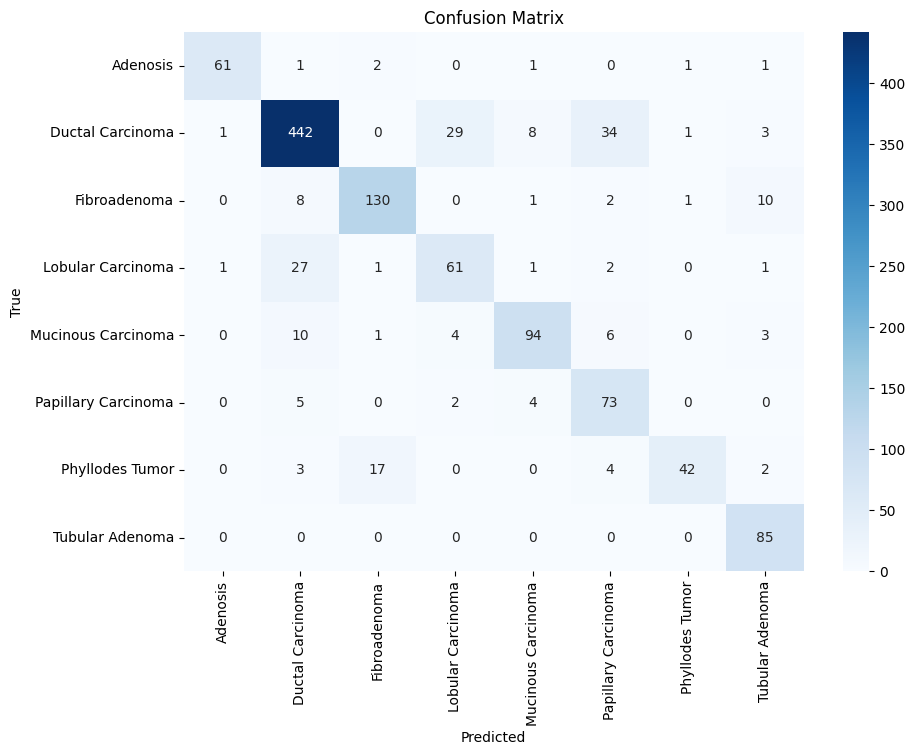

Plotted confusion matrix.
Evaluation complete. Returning results.


{'accuracy': 0.8330522765598651,
 'classification_report': {'Adenosis': {'precision': 0.9682539682539683,
   'recall': 0.9104477611940298,
   'f1-score': 0.9384615384615385,
   'support': 67.0},
  'Ductal Carcinoma': {'precision': 0.8911290322580645,
   'recall': 0.8532818532818532,
   'f1-score': 0.8717948717948718,
   'support': 518.0},
  'Fibroadenoma': {'precision': 0.8609271523178808,
   'recall': 0.8552631578947368,
   'f1-score': 0.858085808580858,
   'support': 152.0},
  'Lobular Carcinoma': {'precision': 0.6354166666666666,
   'recall': 0.648936170212766,
   'f1-score': 0.6421052631578947,
   'support': 94.0},
  'Mucinous Carcinoma': {'precision': 0.8623853211009175,
   'recall': 0.7966101694915254,
   'f1-score': 0.8281938325991189,
   'support': 118.0},
  'Papillary Carcinoma': {'precision': 0.6033057851239669,
   'recall': 0.8690476190476191,
   'f1-score': 0.7121951219512195,
   'support': 84.0},
  'Phyllodes Tumor': {'precision': 0.9333333333333333,
   'recall': 0.6176470

In [ ]:
fitted_vgg16_multiclass = load_model('src\models\VGG16_multiclass.h5\saved_model.h5')
evaluate_model(fitted_vgg16_multiclass, classification_type='multiclass')

**InceptionV3**

In [ ]:
def multiclass_classification_inceptionv3_model(input_shape=(224, 224, 3), trainable_layers=200, learning_rate=0.0001):
    
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # train some layers and freeze others
    for layer in base_model.layers[:-trainable_layers]:
        layer.trainable = False
    for layer in base_model.layers[-trainable_layers:]:
        layer.trainable = True

    model = Sequential()
    
    model.add(base_model)
    
    model.add(GlobalAveragePooling2D())
    
    model.add(Dense(1024, activation='relu'))
    
    model.add(Dense(8, activation='softmax'))
    
    # low learning rate for fine tuning
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [ ]:
train_gen, val_gen, test_gen, class_weights, steps_per_epoch = preproc_pipeline(image_resolution=(224, 224), 
                                                    classification_type='multiclass',
                                                    use_data_augmentation=True,
                                                    augmented_images_per_image=5,
                                                    batch_size=32)
                                                    
inceptionv3_multiclass = multiclass_classification_inceptionv3_model()

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-7)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
callbacks = [reduce_lr, early_stopping]

fitted_inceptionv3_multiclass = train_model(train_gen, val_gen, inceptionv3_multiclass, callbacks=callbacks, class_weights=class_weights, epochs=40, steps_per_epoch=steps_per_epoch)